In [1]:
# IE532Project_Covid19_Patient_Hospital_Assignment_Optimization
# Prof.Chrysafis Vogiatzis
# Chang Sun/Rui Huang
import numpy as np
from numpy import random
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from itertools import product

In [2]:
def patient_hospital_assignment(home_file, hospital_file, age_file, path_file, treatment_file, weights):
    # initialize directed graph
    G = nx.DiGraph()
    
    # load files
    df_home = pd.read_csv(home_file, index_col=0)
    
    df_hospital = pd.read_csv(hospital_file, index_col=0)
    
    df_age = pd.read_csv(age_file, index_col=0)
    # normalize
    df_age.loc[:, 'Recovery_time'] = list(df_age.loc[:, 'Recovery_time']/sum(df_age.loc[:, 'Recovery_time']))
    
    df_path = pd.read_csv(path_file, index_col=0)
    
    df_treatment = pd.read_csv(treatment_file, index_col=0)
    # normalize
    df_treatment.loc[:, 'Price'] = list(df_treatment.loc[:, 'Price']/sum(df_treatment.loc[:, 'Price']))
    
    h_in_nodes = {}
    h_out_nodes = {}
    h_out_nodes_list = []
    # add hospital-treatment-age in and out nodes and in-out edges
    # for every hospital
    for h, h_row in df_hospital.iterrows():
        h_in_nodes[h] = {}
        h_out_nodes[h] = {}
        # for every treatment
        for t, t_row in df_treatment.iterrows():
            h_in_nodes[h][t] = {}
            h_out_nodes[h][t] = {}
            # for every age group
            for a, a_row in df_age.iterrows():
                # hospital-treatment-age in
                name_in = h + ' ' + t + ' ' + a + ' in'
                # hospital-treatment-age out
                name_out = h + ' ' + t + ' ' + a + ' out'
                # save
                h_out_nodes_list.append(name_out)
                h_in_nodes[h][t][a] = name_in
                h_out_nodes[h][t][a] = name_out
                # define cost
                cost = weights['rate']*a_row['Death']*t_row['Reduction_mortality_rate'] +\
                       weights['price']*t_row['Price'] +\
                       weights['time']*a_row['Recovery_time']*t_row['Reduction_recovery_time_rate']
                cost = round(cost, 5)
                # define capacity
                treatment_capacity = int(h_row[t])
                # add nodes
                G.add_node(name_in,
                           demand = 0
                          )
                G.add_node(name_out,
                           demand = 0
                          )
                # add edge
                G.add_edge(name_in, 
                           name_out,
                           capacity = treatment_capacity,
                           weight = cost
                          )
    
    home_nodes = {}
    total_patients = 0
    # add home-age node
    # for every home
    for h, h_row in df_home.iterrows():
        home_nodes[h] = {}
        h_parients = 0
        # for every age group
        for a, a_row in df_age.iterrows():
            # home-age node
            name = h + ' ' + a
            # save
            home_nodes[h][a] = name
            # define demand
            patient_num = int(h_row['Residents']*0.02*a_row['Positive_percentage'])
            # update
            total_patients += patient_num
            h_parients += patient_num
            # add node
            G.add_node(name,
                       demand = -patient_num
                      )
        home_nodes[h]['patient'] = h_parients
    
    # add a virtual node
    G.add_node('terminal',
               demand = total_patients
              )
    
    # connect each home-age node to corresponding hospital-treatment-age in node
    for home, hospital in product(df_home.index, df_hospital.index):
        # get the shortest path time
        path_time = df_path.loc[home, hospital]
        # define cost
        cost = round(weights['time']*((path_time/60.0)/60.0)/24.0, 5)
        for a in df_age.index:
            home_node = home_nodes[home][a]
            #print(home_node)
            for t in df_treatment.index:
                hospital_node = h_in_nodes[hospital][t][a]
                #print(hospital_node)
                # add edge
                G.add_edge(home_node,
                           hospital_node,
                           capacity = total_patients,
                           weight = cost
                          )
                
    # connect each home-age node to terminal with a self-quarantine 'cost'
    for h, h_row in df_home.iterrows():
        for a, a_row in df_age.iterrows():
            home_node = home_nodes[home][a]
            # define cost
            cost = weights['rate']*a_row['Death'] +\
                   weights['time']*a_row['Recovery_time']
            cost = round(cost, 5)
            # define capacity
            patient_num = int(h_row['Residents']*0.02*a_row['Positive_percentage'])
            # add edge
            G.add_edge(home_node,
                       'terminal',
                       capacity = patient_num,
                       weight = cost
                      )
    
    # connect each hospital-treatment-age out node to terminal as an discharge edge
    for hospital_node in h_out_nodes_list:
        G.add_edge(hospital_node,
                   'terminal',
                   capacity = total_patients,
                   weight = 0.0
                  )
    
    # layout
    pos = nx.spring_layout(G)
    
    #assignment = nx.min_cost_flow(G, demand='demand', capacity='capacity', weight='weight')
    return G, pos

In [3]:
# test
weights = {'time':0.2, 'price':0.1, 'rate':0.7}
home_file = 'Home.csv' 
hospital_file = 'Hospitals.csv' 
age_file = 'Age_group.csv' 
path_file = 'Travel_time.csv' 
treatment_file = 'Treatment.csv'
G, pos = patient_hospital_assignment(home_file, hospital_file, age_file, path_file, treatment_file, weights)

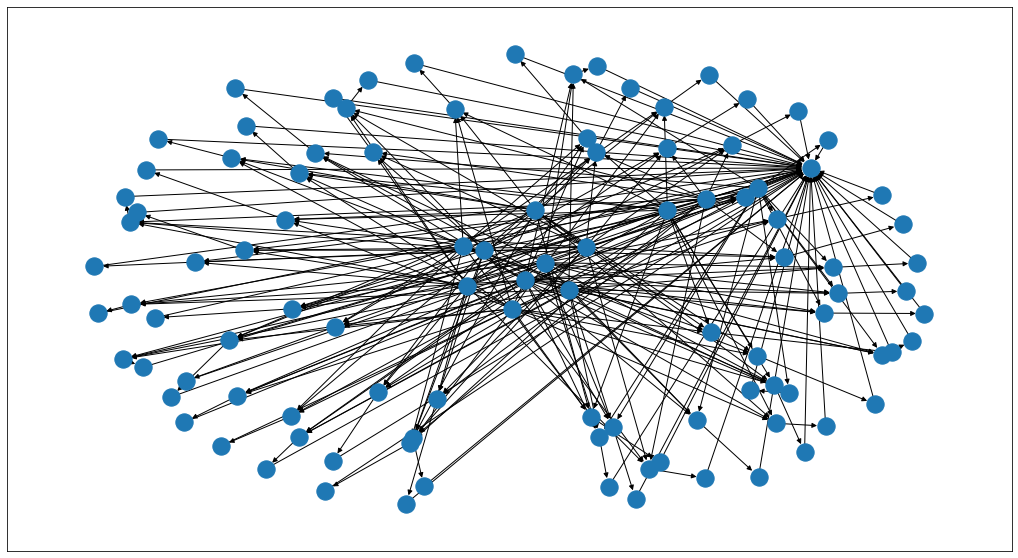

In [4]:
plt.figure(figsize=(18,10))
nx.draw_networkx(G, pos, with_labels=False)

In [5]:
for node in G.nodes(data=True):
    print(node)
    
for edge in G.edges(data=True):
    print(edge)

('The Pavilion Non-ICU Beds 0-29 years in', {'demand': 0})
('The Pavilion Non-ICU Beds 0-29 years out', {'demand': 0})
('The Pavilion Non-ICU Beds 30-64 years in', {'demand': 0})
('The Pavilion Non-ICU Beds 30-64 years out', {'demand': 0})
('The Pavilion Non-ICU Beds 65+ years in', {'demand': 0})
('The Pavilion Non-ICU Beds 65+ years out', {'demand': 0})
('The Pavilion ICU Beds 0-29 years in', {'demand': 0})
('The Pavilion ICU Beds 0-29 years out', {'demand': 0})
('The Pavilion ICU Beds 30-64 years in', {'demand': 0})
('The Pavilion ICU Beds 30-64 years out', {'demand': 0})
('The Pavilion ICU Beds 65+ years in', {'demand': 0})
('The Pavilion ICU Beds 65+ years out', {'demand': 0})
('The Pavilion Ventillator 0-29 years in', {'demand': 0})
('The Pavilion Ventillator 0-29 years out', {'demand': 0})
('The Pavilion Ventillator 30-64 years in', {'demand': 0})
('The Pavilion Ventillator 30-64 years out', {'demand': 0})
('The Pavilion Ventillator 65+ years in', {'demand': 0})
('The Pavilion Ve

In [6]:
assignment = nx.min_cost_flow(G, demand='demand', capacity='capacity', weight='weight')

KeyboardInterrupt: 

In [34]:
def f(h):
    return 1 - h + h**2/2 - h**3/6 + h**4/24

2.785300000011696


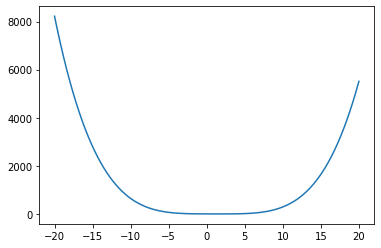

In [41]:
h = np.linspace(-20,20,100)
plt.plot(h, f(h))
for h in np.arange(1, 5, 0.00001):
    if f(h) >= 1:
        print(h)
        break

In [30]:
import sympy as sym

In [32]:
x = sym.Symbol('x')
f = sym.Eq(1 - x + x**2/2 - x**3/6 + x**4/24, 1)
sym.solve(f, x)

[0,
 4/3 + 2*(-1/2 - sqrt(3)*I/2)*(43/54 + sqrt(29)/6)**(1/3) - 10/(9*(-1/2 - sqrt(3)*I/2)*(43/54 + sqrt(29)/6)**(1/3)),
 4/3 - 10/(9*(-1/2 + sqrt(3)*I/2)*(43/54 + sqrt(29)/6)**(1/3)) + 2*(-1/2 + sqrt(3)*I/2)*(43/54 + sqrt(29)/6)**(1/3),
 -10/(9*(43/54 + sqrt(29)/6)**(1/3)) + 4/3 + 2*(43/54 + sqrt(29)/6)**(1/3)]

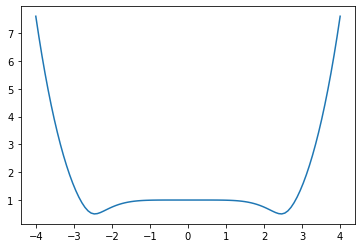

In [65]:
def f(h):
    temp = 1 + h*1j - h**2/2 - h**3/6 * 1j + h**4/24
    output =  np.absolute(temp)
    return output
h = np.linspace(-4,4,100)
plt.plot(h, f(h))

In [70]:
np.abs(3 + 4j)

5.0